In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm
import matplotlib.colors as mcolors
from copy import deepcopy
from gudhi.representations import Landscape, PersistenceImage

from topofisher.input_simulators.noisy_ring import CircleSimulator

from topofisher.filtrations.numpy.alphaDTML import AlphaDTMLayer

from topofisher.vectorizations.numpy.custom_vectorizations import TOPK
from topofisher.vectorizations.numpy.vectorization_layer import VectorizationLayers
from topofisher.vectorizations.numpy.shorthand_layers import PersistenceImages, PersistenceLandscapes

from topofisher.fisher.Fisher import show_fm_and_bias
from topofisher.fisher.imnn import IMNNLayer, MopedLayer, ExtraDimLayer
from topofisher.fisher.plot_fisher_stats import plotContours2D, plotSummaryDerivativeHists, plot_derivative_convergence


from topofisher.pipelines.circle import CirclePipeline
from topofisher.pipelines.convergence_checks import fisher_estimates_wrt_step_size
from topofisher.pipelines.utils import readFromFile, writeToFile

import gudhi.representations as gdr
import gudhi.tensorflow.perslay as prsl

2023-09-23 19:13:09.284905: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-23 19:13:13.374887: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Importlib

In [286]:
import importlib
import topofisher
importlib.reload(topofisher.fisher.Fisher)
importlib.reload(topofisher.fisher.imnn)

importlib.reload(topofisher.filtrations.numpy.filtration_layers)
importlib.reload(topofisher.filtrations.numpy.alphaDTML)

importlib.reload(topofisher.vectorizations.numpy.vectorization_layer)
importlib.reload(topofisher.vectorizations.numpy.shorthand_layers)
importlib.reload(topofisher.input_simulators.noisy_ring)
importlib.reload(topofisher.pipelines.pipeline)
importlib.reload(topofisher.pipelines.circle)

from topofisher.input_simulators.noisy_ring import CircleSimulator

from topofisher.filtrations.numpy.alphaDTML import AlphaDTMLayer

from topofisher.vectorizations.numpy.custom_vectorizations import TOPK
from topofisher.vectorizations.numpy.vectorization_layer import VectorizationLayers
from topofisher.vectorizations.numpy.shorthand_layers import PersistenceImages, PersistenceLandscapes

importlib.reload(topofisher.fisher.imnn)

from topofisher.fisher.Fisher import fisherFromVecs
from topofisher.fisher.imnn import IMNNLayer, FisherLayer, MopedLayer, ExtraDimLayer
from topofisher.fisher.plot_fisher_stats import plotContours2D, plotSummaryDerivativeHists, plot_derivative_convergence


from topofisher.pipelines.circle import CirclePipeline

## Initalizing

In [320]:
circle_pipeline = readFromFile("pipeline_m_p9_ns_4K_dtheta_p01.pkl")

## Landscapes

In [ ]:
landscape_layer = PersistenceLandscapes(num_landscapes = [50, 20], resolutions = [30, 30])
all_landscapes = []
for pds in circle_pipeline.all_persistence_diagrams:
    vecs = landscape_layer.vectorize_persistence_diagrams(pds)
    all_landscapes.append(vecs)

### Preparing the persistence diagrams

In [305]:
def stack_ragged(tensors):
    tensors = [tf.constant(item) for item in tensors]
    values = tf.concat(tensors, axis = 0)
    lens = tf.stack([tf.shape(t, out_type=tf.int64)[0] for t in tensors])
    return tf.RaggedTensor.from_row_lengths(values, lens)

def transpose(all_dgms):
    dgms_transpose = [list(map(list, zip(*dgms))) for dgms in all_dgms]
    return list(map(list, zip(*dgms_transpose)))
    
def list_to_ragged_tensor(input_dgms, num_theta, num_hom_dim):
    all_pds = transpose(input_dgms)
    all_pds_list = []
    for pds in all_pds:
        pds_list = []
        for dgms in pds: # Iterating over hom_dim
            ragged_dgm = stack_ragged(dgms)
            all_pds_list.append(ragged_dgm)
    stacked = tf.concat(all_pds_list, axis = 0)
    t1 = tf.RaggedTensor.from_uniform_row_length(stacked, num_hom_dim)
    t2 = tf.RaggedTensor.from_uniform_row_length(t1, num_theta)
    return t2

circle_pipeline_pi = readFromFile("pipeline_m_p9_ns_10K_dtheta_p01.pkl")
all_dgms = [[item for item in pds] \
        for pds in circle_pipeline_pi.all_persistence_diagrams] # 5, hom_dims, num_sims, None, 2
t2 = list_to_ragged_tensor(all_dgms, num_theta = 5, num_hom_dim = 2)

### Perslaying

In [306]:
weight = prsl.PowerPerslayWeight(1. ,0.)

phis = [prsl.TentPerslayPhi(item.grid_) for item in landscape_layer.vectorizations]

perslays = [prsl.Perslay(phi=phis[0], weight=weight, perm_op='top50', rho=rho),\
            prsl.Perslay(phi=phis[1], weight=weight, perm_op='top20', rho=rho)]

In [307]:
model = tf.keras.Sequential(
    [   ExtraDimLayer(PerslayLayer(perslays)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(2)
    ]
)

In [308]:
perslay_vec_layer = IMNNLayer(model, verbose = 1, epochs = 7, data_splits = [0.4, 0.2, 0.4], \
                            callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3)], transpose = False)
fisher = perslay_vec_layer.computeFisher(t2, circle_pipeline_pi.delta_theta)

Epoch 1/7
8/8 [==============================] - 64s 8s/step - loss: -12.9764 - val_loss: -15.5806
Epoch 2/7
8/8 [==============================] - 65s 8s/step - loss: -15.8124 - val_loss: -15.9431
Epoch 3/7
8/8 [==============================] - 66s 9s/step - loss: -16.1208 - val_loss: -16.0996
Epoch 4/7
8/8 [==============================] - 66s 9s/step - loss: -16.2596 - val_loss: -16.1900
Epoch 5/7
8/8 [==============================] - 64s 8s/step - loss: -16.3510 - val_loss: -16.2371
Epoch 6/7
8/8 [==============================] - 64s 8s/step - loss: -16.4146 - val_loss: -16.2718
Epoch 7/7
8/8 [==============================] - 62s 8s/step - loss: -16.4748 - val_loss: -16.3020


### Results and histograms

In [309]:
show_fm_and_bias(fisher)

FM =  [3392.39  143.93  143.93 3809.25]
Fractional bias =  [0.19 0.22]


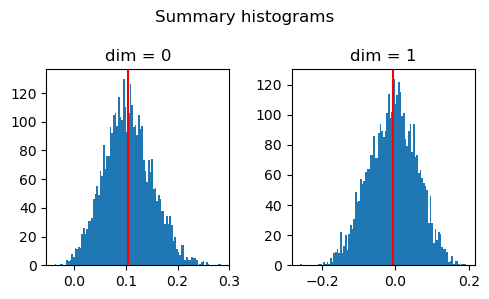

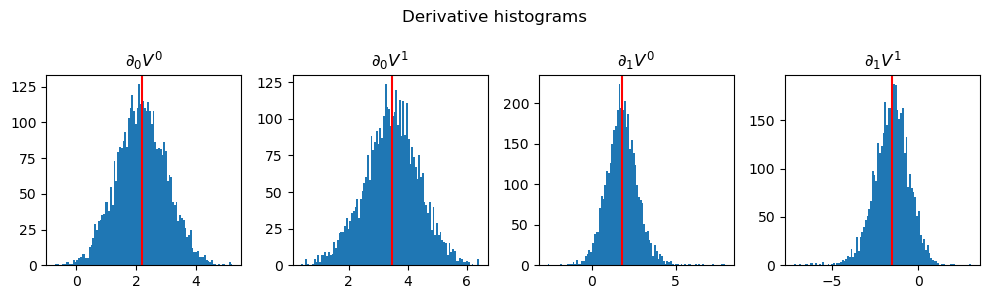

In [311]:
plotSummaryDerivativeHists(fisher)

### Final grid - initial grid

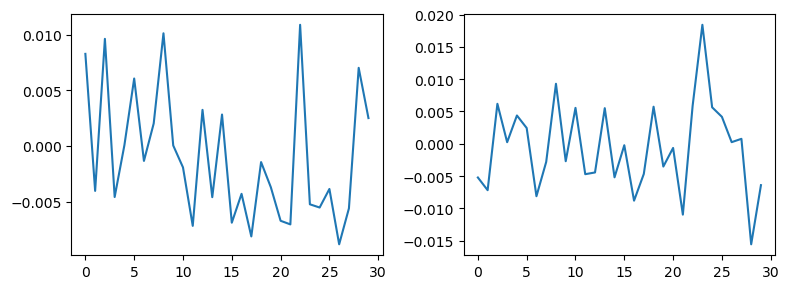

In [316]:
ncols = 2
fig, axes = plt.subplots(nrows=1, ncols= ncols, \
                         figsize=(3 * ncols + 2 , 3))
for idx in [0,1]:
    axes[idx].plot(phis[idx].samples - landscape_layer.vectorizations[idx].grid_)
plt.tight_layout()
plt.show()

## Persistence images

### Preparing the persistence diagrams

In [324]:
def stack_ragged(tensors):
    tensors = [tf.constant(item) for item in tensors]
    values = tf.concat(tensors, axis = 0)
    lens = tf.stack([tf.shape(t, out_type=tf.int64)[0] for t in tensors])
    return tf.RaggedTensor.from_row_lengths(values, lens)

def transpose(all_dgms):
    dgms_transpose = [list(map(list, zip(*dgms))) for dgms in all_dgms]
    return list(map(list, zip(*dgms_transpose)))
    
def list_to_ragged_tensor(input_dgms, num_theta, num_hom_dim):
    all_pds = transpose(input_dgms)
    all_pds_list = []
    for pds in all_pds:
        pds_list = []
        for dgms in pds: # Iterating over hom_dim
            ragged_dgm = stack_ragged(dgms)
            all_pds_list.append(ragged_dgm)
    stacked = tf.concat(all_pds_list, axis = 0)
    t1 = tf.RaggedTensor.from_uniform_row_length(stacked, num_hom_dim)
    t2 = tf.RaggedTensor.from_uniform_row_length(t1, num_theta)
    return t2

circle_pipeline_pi = readFromFile("pipeline_m_p9_ns_4K_dtheta_p01.pkl")
all_dgms = [[item for item in pds] \
        for pds in circle_pipeline_pi.all_persistence_diagrams] # 5, hom_dims, num_sims, None, 2
t2 = list_to_ragged_tensor(all_dgms, num_theta = 5, num_hom_dim = 2)

### Preparing perslay object

In [325]:
res = 24
extents = [item.im_range_fixed_.reshape((2,2)) for item in pi_vec_layer.vectorizations]
rho = tf.identity
phis = [prsl.GaussianPerslayPhi((res, res), extents[0], 3e-2), prsl.GaussianPerslayPhi((res, res), extents[1], 5e-2)]
weights = [prsl.PowerPerslayWeight(1.,tf.Variable(2.)), prsl.PowerPerslayWeight(1.,tf.Variable(2.))]
perm_op = tf.math.reduce_sum
perslays = [prsl.Perslay(phi=phis[0], weight=weights[0], perm_op=perm_op, rho=rho),\
            prsl.Perslay(phi=phis[1], weight=weights[1], perm_op=perm_op, rho=rho)]


In [326]:
model = tf.keras.Sequential(
    [   ExtraDimLayer(PerslayLayer(perslays)),
        ExtraDimLayer(tf.keras.layers.Conv2D(8, (3,3), padding='same', activation = "relu", input_shape=(res, res, 2))),
        ExtraDimLayer(tf.keras.layers.MaxPooling2D((2, 2), strides = 2)),
        ExtraDimLayer(tf.keras.layers.Flatten()),
        tf.keras.layers.Dense(12, activation="relu"),
        tf.keras.layers.Dense(2)
    ]
)

In [327]:
perslay_vec_layer = IMNNLayer(model, verbose = 1, epochs = 7, data_splits = [0.4, 0.2, 0.4], \
                            callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3)], transpose = False)
fisher = perslay_vec_layer.computeFisher(t2, circle_pipeline_pi.delta_theta)

Epoch 1/7
4/4 [==============================] - 1432s 368s/step - loss: -8.5223 - val_loss: -12.5511
Epoch 2/7
4/4 [==============================] - 1281s 326s/step - loss: -12.7752 - val_loss: -13.6379
Epoch 3/7
4/4 [==============================] - 1211s 314s/step - loss: -13.7988 - val_loss: -14.2645
Epoch 4/7
4/4 [==============================] - 1245s 327s/step - loss: -14.3690 - val_loss: -14.6563
Epoch 5/7
4/4 [==============================] - 1290s 329s/step - loss: -14.7874 - val_loss: -14.9388
Epoch 6/7
4/4 [==============================] - 1263s 322s/step - loss: -15.0916 - val_loss: -15.1665
Epoch 7/7
4/4 [==============================] - 1211s 313s/step - loss: -15.3290 - val_loss: -15.3461


In [328]:
show_fm_and_bias(fisher)

FM =  [2636.56 -398.2  -398.2  2009.72]
Fractional bias =  [0.21 0.38]


In [331]:
weights[1].power

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.9918178>

## Rough

### Cheking if perslay matches the PI from gudhi

In [211]:

%timeit -n 1 -r 1 vectors = perslay(diagrams[:4000])

7.35 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


5.4796157 0.11540476
5.479616301749681 0.1154047302944399


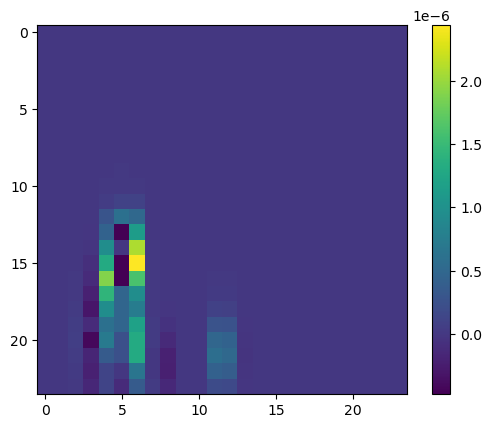

In [6]:
vectors = perslay(diagrams[:10])

res = 24
pi_vec_layer = PersistenceImages(resolutions = [[res, res], [res, res]], bandwidths = [3e-2, 5e-2])
all_vecs = []
for pds in circle_pipeline.all_persistence_diagrams[:][:][:10]:
    vecs = pi_vec_layer.vectorize_persistence_diagrams(pds)
    all_vecs.append(vecs)
all_vecs = tf.stack(all_vecs)

ind = 7

print(np.max(vectors[ind,:,:,0].numpy()), np.mean(vectors[ind,:,:,0].numpy()))
print(np.max(all_vecs[0, ind, :, :, 1]), np.mean(all_vecs[0, ind, :, :, 1]))

plt.figure()
plt.imshow(np.flip(all_vecs[0, ind, :, :, 1].numpy(),0))
cb = plt.colorbar()
plt.show()

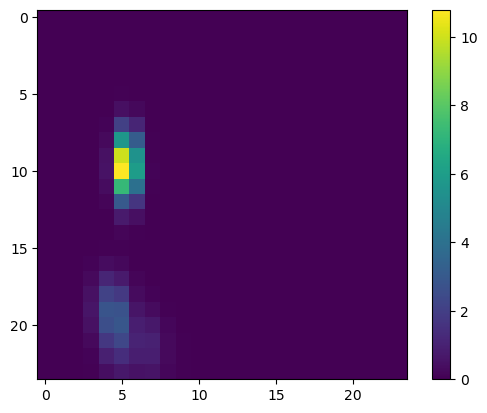

In [335]:
plt.figure()
plt.imshow(np.flip(all_vecs[0, 2, :, :, 1].numpy(),0))
cb = plt.colorbar()
plt.show()

In [336]:
extents

[array([[9.17267919e-01, 2.24133515e+00],
        [7.41481781e-05, 8.99313688e-01]]),
 array([[1.03501081e+00, 3.21200657e+00],
        [2.38418579e-07, 7.95339227e-01]])]

In [ ]:
%history